# Team Ares -- Task 2 Report -- Fall 2020
## Contributions:
### Cody Shearer
- Code contributions:
  - Created script for and generated training/testing data 
  - Modified zhymir's script to train model only on benign samples
  - Wrote script to evaluate and save results
- Report contributions:
  - Informal Breakdown of Our Approach
  - Introduction
  - Generating Training and Testing Data
  - Training
  - Strategy Model Training and Validation Metrics plot/code
  - Testing
  - Citations
- Managed team repository, merging changes
- Organized discord channel, assigned tasks, setup team meetings, etc.

### Zhymir Thompson
- Created script to generate and save reshaped training/testing data
- Created models to use train/testing data
- Created script to train model and save results
- Created script to parse history object dictionary for data to plot (currently plots loss and accuracy)

### Mahmudul Hasan

- Created models to use train/testing data
- Created script to train model and save results

### Vincent Davidson

- Discussed with team about plan 
___

## Informal Breakdown of Our Approach
I've broken task 2 down into three steps. The first is to create some training data, from which we can learn an ensemble strategy. The second is to select a learning model, then train and test variations of that model. The third is to summarize our results and approach in the report. Throughout the entire process and for each step you complete, write down a summary of what you did and what you learned (where necessary). This will save us a lot of time when writing the report. Also, keep a high-level list of contributions you make to the task; it is your responsiblity to make sure you get credit for your work.

1. generate training/test data from Athena as (X,Y), where:
  1. X is a set of predictions from athena
    1. I'm thinking we use the adversarial examples provided in the /data/ folder. This will require understanding how the AEs are stored in the .npy files. 
    2. Once we understand how to use the AEs from the .npy files, we should select a subset of them, ensuring we do not introduce bias into our model by using too many of any one type of AE. We may even decide to include some benign samples in the mix of training/testing data. Whatever we use, let's *be sure to use equal amounts of AEs from each attack type*.
  2. Y is a set of true labels that matches with our selected AEs
    1. We should find out how to get predictions from a weak defense(WD) (see below table for an example of what I mean).
    2. We then need to select a set of WDs (or just use all of 72 of them) to create training data

Once we are done with this first part, we should have data that looks something like this table

| AE_id | WD1                   | WD2                   | ... | Y   |
|-------|-----------------------|-----------------------|-----|-----|
| 1     | [0.1,0.4,0,0,...,0.1] | [0.1,0,0.8,0,...,0.1] | ... | 3   |
| 2     | [0.6,0,0,0.3,...,0.1] | [0,0,0.3,0.1,...,0.2] | ... | 1   |
| ...   | ....                  | ...                   | ... | ... |
| n     | [0.1,0.4,0,0,...,0.1] | [0.1,0,0.8,0,...,0.1] | ... | 9   |

where:
- where AE_id is just an index we associate with the training sample
- WD# is the nth weak defense we choose to use
- predictions from the weak defenses (e.g [0.1,0.4,0,0,...,0.1]) are a probability distribution from 0 through 9, where the WD assigns a probability (makes a prediction) that a particular number is the true label.
- Y is the true (correct) label for that AE or benign sample

2. Learn an ensemble strategy
  1. We need to select a ML model for learning. Logistic regression is the most basic form of categorical predicion model, but we could also use some type of decision tree. Whatever we use, let's stick to that one model.
  2. We should then decide what metrics we wish to track during training and find out how to do this with Keras. We must at the very least track model accuracy (loss) over time.
    1. Run through [these tutorials](https://www.tensorflow.org/tutorials) (no setup required, tutorials can be run in google collab).
    2. Once you've finished some of the basic tutorials (it's up to you to figure out how much you will need), figure out how to track model loss (accuracy) over each training iteration for one of the example models you create. Figure out how to save this and any other metrics you use to a csv file, where each row is a training step and each column is a metric (like model loss). In addition, figure out how to plot the data in the csv.
  2. Whatever model we select, train a few (3 to 5) variations of the ML model by changing the hyper-parameters that we could use for that model. Note that this selection of variations won't occur simultaneously. Note also that we should separate the data we generated in step 1 into a training and a testing set. How we separate this (e.g. 80% training 20% testing) might depend on the model we choose.
    1. Select a set of hyper-parameters
    2. Train the model with that selection of hyper-parameters, tracking the model loss (and any other selected metrics) over each training iteration. You will store these metrics in a csv file, where each row is a training step and each column is a metric (like model loss).
    3. As you train the model, print the model loss after every iteration. A succesful hyper-parameter selection will result in the model loss decreasing after each training step. If it doesn't decrease or stops decreasing, stop the training. Either the selection of hyper-parameters is bad and your loss won't converge, or your model has already converged and further training won't help. 
    3. After your model has converged, plot the resulting metrics.
    4. Save the plots, the learned weights/training parameters, and the metrics you tracked during training. Please name these intelligently (include the name of the model, and any relevant hyper-parameters in the file name), any member of the group should be able to understand what the contents of the file are without opening them.
    5. Place the files in their respective folders in Task2/. If a file doesn't appear to fit in any folder, ask in the discord chat where to put it.
    6. Repeat the above steps another 2 to 4 times, [adjusting the hyper-parameters you select](https://towardsdatascience.com/guide-to-choosing-hyperparameters-for-your-neural-networks-38244e87dafe). Selection of these hyper-parameters is uncertain, so you will need to use any knowledge and experience you have to adjust these, based on the results you get. 
3. Write the report. This should detail your approaches, results, what you learned, conclusions, etc. Imagine telling yourself what you wish you knew before starting the task. If you kept a summary of what you did and what you learned (as I suggested from the beginning) this should be easy.
  1. Introduce the approaches that are used in the task.
  2. Experimental settings --- the values of the tunable parameters for each variant.
  3. Evaluation and necessary analysis.
  4. Contribution of individual team members.
  5. Citations to all related works.
  
## Introduction
Machine learning models have proven capable of learning many complex tasks, however, [their tendency to rely on extraneous information](https://spectrum.ieee.org/cars-that-think/transportation/sensors/slight-street-sign-modifications-can-fool-machine-learning-algorithms) makes their use in mission critical applications an important and difficult challenge. For this reason, extensive research has been conducted on defensive against adversarial attacks.

In their work on [ATHENA](https://arxiv.org/abs/2001.00308), Ying et al. solve the problem of adversarial defense, not as a technique, but as a framework, wherein a variable number of weak adversarial defenses (an ensemble) are trained and their collective predictions are used to create a response to adversarial attacks, the robustness and overhead of which are inversely correlated and controlled by the number of weak defenses. The method of collecting these predictions is called an "ensemble strategy" and is the main topic of our exploration.

While Ying et al. used a fixed ensemble strategy, where a final prediction is attained by a majority vote amongst the weak defenses, we propose a learning based ensemble strategy.    
  
## Generating Training and Testing Data
We collected raw predictions as logits from 19 sets of 10k MNIST images run through 16 weak defenses using `src/scripts/cody_scripts/generate_test_data.py` and saved them at . 
  
While the original plan was to collect raw predicitons as logits from 73 models (the original CNN plus the 72 weak defenses from `/src/configs/demo/athena-mnist.json`) and all 45 sets of images (the original MNIST dataset, along with 44 adversarial examples from `/src/configs/demo/data-mnist.json`), the predictions from one model for one set of 10k images comes to ~35MB, so 73 models x 45 MNIST sets x 35MB = 114.975GB. This wasn't feasible, so we selected a representative sample of weak defenses and adversarial examples, where we have 16 cnn models x 19 MNIST sets x 35MB = 10.64GB. This was further compressed with numpy's `savez_compressed` function within the `src/scripts/cody_scripts/generate_test_data.py` script, bringing the saved predictions at `Task2/data/predictions.npz` down to ~126MB. As github has a maximum file size limit of 100MB, we use 7-zip to store the predicitions in 3 parts.
  
### Weak Defenses
Our selection of weak defenses used to generate the predictions includes one model for each "type" of weak defense found in `/src/configs/task2/cody_configs/athena-mnist.json` (also available as a set of "active_wds"): 
  - model-mnist-cnn-clean.h5
  - model-mnist-cnn-rotate90.h5
  - model-mnist-cnn-shift_left.h5
  - model-mnist-cnn-flip_horizontal.h5
  - model-mnist-cnn-affine_vertical_compress.h5
  - model-mnist-cnn-morph_erosion.h5
  - model-mnist-cnn-augment_samplewise_std_norm.h5
  - model-mnist-cnn-cartoon_mean_type1.h5
  - model-mnist-cnn-quant_4_clusters.h5
  - model-mnist-cnn-distort_x.h5
  - model-mnist-cnn-noise_gaussian.h5
  - model-mnist-cnn-filter_sobel.h5
  - model-mnist-cnn-compress_jpeg_quality_80.h5
  - model-mnist-cnn-denoise_tv_chambolle.h5
  - model-mnist-cnn-geo_swirl.h5
  - model-mnist-cnn-seg_gradient.h5
  
### Adversarial (and clean) Examples
Our selection of samples includes the original MNIST dataset, along with two sets of samples per "type" of transformation found in `/src/configs/demo/data-mnist.json`. For each transformation, we select the two sets of AEs that are the most different. You can find the following at `/src/configs/task2/cody_configs/data-mnist.json`:
  - test_BS-mnist-clean.npy
  - test_AE-mnist-cnn-clean-fgsm_eps0.1.npy
  - test_AE-mnist-cnn-clean-fgsm_eps0.3.npy
  - test_AE-mnist-cnn-clean-bim_ord2_eps0.75.npy
  - test_AE-mnist-cnn-clean-bim_ord2_eps1.2.npy
  - test_AE-mnist-cnn-clean-bim_ordinf_eps0.075.npy
  - test_AE-mnist-cnn-clean-bim_ordinf_eps0.12.npy
  - test_AE-mnist-cnn-clean-cw_l2_lr0.0098.npy
  - test_AE-mnist-cnn-clean-cw_l2_lr0.018.npy
  - test_AE-mnist-cnn-clean-deepfool_l2_overshoot3.npy
  - test_AE-mnist-cnn-clean-deepfool_l2_overshoot50.npy
  - test_AE-mnist-cnn-clean-jsma_theta0.15_gamma0.5.npy
  - test_AE-mnist-cnn-clean-jsma_theta0.25_gamma0.5.npy
  - test_AE-mnist-cnn-clean-pgd_eps0.075.npy
  - test_AE-mnist-cnn-clean-pgd_eps0.11.npy
  - test_AE-mnist-cnn-clean-mim_eps0.06.npy
  - test_AE-mnist-cnn-clean-mim_eps0.1.npy
  - test_AE-mnist-cnn-clean-onepixel_pxCount15.npy
  - test_AE-mnist-cnn-clean-onepixel_pxCount75.npy
  
## Training
For training, we use the raw predictions from the above 16 weak defenses on *only benign samples*. The model we use is built with keras and has 3 layers: a dense input layer with relu activation, a 'flatten' layer, and a dense softmax output layer. We provide the exact architecture below, complete with layer shape:

In [5]:
from keras.models import load_model
import os

model_root = 'models'
model_filepath = os.path.join(model_root, 'cody_model.h5')
model = load_model(model_filepath, compile=False)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
D1 (Dense)                   (None, 16, 100)           1100      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                16010     
Total params: 17,110
Trainable params: 17,110
Non-trainable params: 0
_________________________________________________________________


We train this model with 8 epochs and a batch size of 10, with 10% of the training data held out for validation. After training finishes, which takes about 20 seconds on our machine, we save the model in `Task2/models/cody_model` and the model history at `Task2/data/cody_model_history`. Code for training can be found at `src/cody_scripts/train_ensemble_model.py`. We plot the metrics collected during training below: 

[Text(0.5, 0, 'epochs'), Text(0.5, 0, 'epochs')]

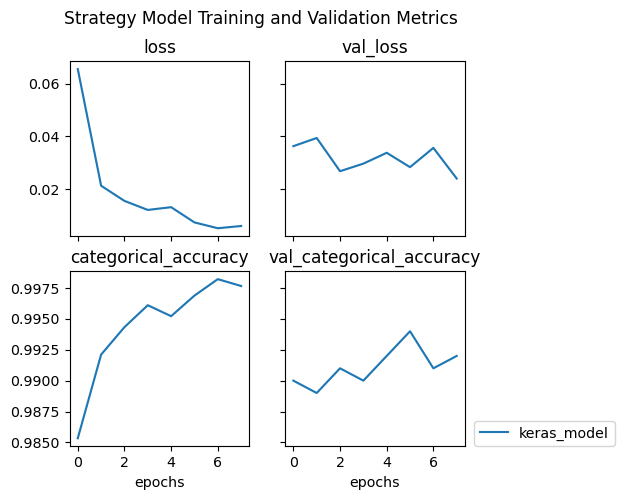

In [2]:
# add src directory to python path
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.file import load_from_json

%matplotlib inline
from matplotlib import pyplot as plt

#### plot current model validation histories:
# add histories for other models here 
history_files = ['./data/cody_model_history']
model_names = ['keras_model']

# don't change anything below this line
metrics = ['loss', 'val_loss', 'categorical_accuracy','val_categorical_accuracy']
histories = [load_from_json(x) for x in history_files]

fig, axs = plt.subplots(2,2,
                        facecolor='w', 
                        sharex=True, sharey='row', 
                        figsize=(5,5), dpi=102)


fig.suptitle('Strategy Model Training and Validation Metrics')

for ax, metric in zip(axs.flatten(), metrics):
    for history, model_name in zip(histories, model_names):
        ax.plot(history[metric], label=model_name)
        ax.set_title(metric)

ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
plt.setp(axs[-1, :], xlabel='epochs')

From the above plot, it appears that the model has converged after 8 epochs, so we continue with evaluation on unseen adversarial examples

## Testing
- We test the model on 18 previously unseen sets of adversarial examples, which can be found in the above section on Adverarial Examples. Code for testing/evaluation can be found at `src/scripts/cody_scripts/evaluate_ensemble_model.py`. Results are saved at `Task2/results/cody_model.csv`, although we summarize them below.

<AxesSubplot:xlabel='Unnamed: 0'>

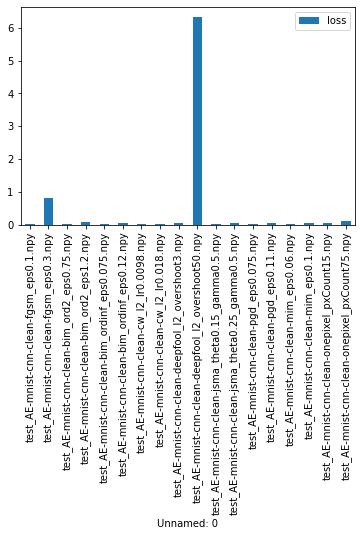

In [6]:
import pandas as pd
results = pd.read_csv('results/cody_model.csv')
results.plot.bar(x='Unnamed: 0', y='loss')

### Adversarial Trained Model

For this model we took a model trained on the benign samples. We then defined a PGD AE designed to attack the ensembles' defenses. We set a loop such that the adversary would generate AEs based on a sample (in this case 1000) of benign samples, the ensemble would train on these generated AEs, and the loop would repeat. The thought was that the model would learn to better understand the weaknesses of the WDs in the ensemble and adjust accordingly. In practice, the method takes far too long to generate AEs, and the return isn't as expected.

#### Data Used
For the experiment we used benign samples to generate PGD-AEs:
data/test_BS-mnist-clean.npy
data/test_Label-mnist-clean.npy

For testing on AEs, we used bim and cw AEs available:

* Task2_Update/Task1_AEs/AE-mnist-cnn-clean-bim_eps0.1_maxiter50.npy
* Task2_Update/Task1_AEs/AE-mnist-cnn-clean-bim_eps0.1_maxiter60.npy
* Task2_Update/Task1_AEs/cw_norm_linf_lr_1e-4_iter_20_eps_0-010_.npy
* Task2_Update/Task1_AEs/AE-mnist-cnn-clean-bim_eps0.3_maxiter50.npy
* Task2_Update/Task1_AEs/cw_norm_l2_lr_1e-5_iter_30_.npy
* Task2_Update/Task1_AEs/cw_norm_linf_lr_1e-4_iter_20_eps_0-020_.npy
* Task2_Update/Task1_AEs/cw_norm_l2_lr_1e-5_iter_50_.npy
* Task2_Update/Task1_AEs/cw_norm_linf_lr_1e-4_iter_10_eps_0-010_.npy
* Task2_Update/Task1_AEs/cw_norm_linf_lr_1e-4_iter_30_eps_0-010_.npy
* Task2_Update/Task1_AEs/cw_norm_l2_lr_1e-5_iter_10_.npy
* Task2_Update/Task1_AEs/cw_norm_l2_lr_1e-3_iter_20_.npy
* Task2_Update/Task1_AEs/AE-mnist-cnn-clean-bim_eps0.2_maxiter60.npy
* Task2_Update/Task1_AEs/AE-mnist-cnn-clean-bim_eps0.3_maxiter70.npy
* Task2_Update/Task1_AEs/AE-mnist-cnn-clean-bim_eps0.3_maxiter60.npy
* Task2_Update/Task1_AEs/cw_norm_linf_lr_1e-4_iter_10_eps_0-20_.npy
* Task2_Update/Task1_AEs/cw_norm_linf_lr_1e-4_iter_50_eps_0-20_.npy
* Task2_Update/Task1_AEs/cw_norm_linf_lr_1e-4_iter_50_eps_0-010_.npy
* Task2_Update/Task1_AEs/cw_norm_l2_lr_1e-3_iter_50_.npy
* Task2_Update/Task1_AEs/cw_norm_l2_lr_1e-5_iter_20_.npy
* Task2_Update/Task1_AEs/AE-mnist-cnn-clean-bim_eps0.2_maxiter70.npy
* Task2_Update/Task1_AEs/cw_norm_l2_lr_1e-3_iter_10_.npy
* Task2_Update/Task1_AEs/cw_norm_l2_lr_1e-3_iter_30_.npy
* Task2_Update/Task1_AEs/AE-mnist-cnn-clean-bim_eps0.1_maxiter70.npy
* Task2_Update/Task1_AEs/cw_norm_linf_lr_1e-4_iter_30_eps_0-020_.npy
* Task2_Update/Task1_AEs/AE-mnist-cnn-clean-bim_eps0.2_maxiter50.npy

#### Testing eval


##### Base Model
|                                                 |    loss|  categorical_accuracy|
|-------------------------------------------------|--------|----------------------|
|test_AE-mnist-cnn-clean-fgsm_eps0.1.npy          |2.397672|                0.0946|
|test_AE-mnist-cnn-clean-fgsm_eps0.3.npy          |2.373861|                0.1051|
|test_AE-mnist-cnn-clean-bim_ord2_eps0.75.npy     |2.423655|                0.1055|
|test_AE-mnist-cnn-clean-bim_ord2_eps1.2.npy      |2.416791|                0.1123|
|test_AE-mnist-cnn-clean-bim_ordinf_eps0.075.npy  |2.407547|                0.0997|

##### PGD Trained Model
|                                                |     loss|  categorical_accuracy|
|------------------------------------------------|---------|----------------------|
|test_AE-mnist-cnn-clean-fgsm_eps0.1.npy          |0.158885 |               0.9860|
|test_AE-mnist-cnn-clean-fgsm_eps0.3.npy          |1.897898 |               0.8260|
|test_AE-mnist-cnn-clean-bim_ord2_eps0.75.npy     |0.159789 |               0.9863|
|test_AE-mnist-cnn-clean-bim_ord2_eps1.2.npy      |0.283937 |               0.9746|
|test_AE-mnist-cnn-clean-bim_ordinf_eps0.075.npy  |0.137420 |               0.9879|

#### Adversarial Testing Evaluation

##### Base Model
|AE                                         |Loss|Categorical Accuracy|
|-------------------------------------------|----|--------------------|
|AE-mnist-cnn-clean-bim_eps0.1_maxiter50.npy| 2.3018479347229004 |0.097  |
|AE-mnist-cnn-clean-bim_eps0.1_maxiter60.npy|2.301830530166626  |0.098 |
|cw_norm_linf_lr_1e-4_iter_20_eps_0-010_.npy| 2.302213430404663 | 0.014 |
|AE-mnist-cnn-clean-bim_eps0.3_maxiter50.npy|2.301875591278076  | 0.116 |
|cw_norm_l2_lr_1e-5_iter_30_.npy|2.3022828102111816  |0.019  |
|cw_norm_linf_lr_1e-4_iter_20_eps_0-020_.npy|2.3022823333740234  | 0.016 |
|cw_norm_l2_lr_1e-5_iter_50_.npy|2.3022799491882324  |0.014  |
|cw_norm_linf_lr_1e-4_iter_10_eps_0-010_.npy|2.30220890045166  |0.018  |
|cw_norm_linf_lr_1e-4_iter_30_eps_0-010_.npy|2.3022162914276123  | 0.017 |
|cw_norm_l2_lr_1e-5_iter_10_.npy|2.3022871017456055  |0.016  |
|cw_norm_l2_lr_1e-3_iter_20_.npy|2.302288293838501  |0.015  |
|AE-mnist-cnn-clean-bim_eps0.2_maxiter60.npy|2.301849365234375  |0.119  |
|AE-mnist-cnn-clean-bim_eps0.3_maxiter70.npy|2.30184268951416  |0.126  |
|AE-mnist-cnn-clean-bim_eps0.3_maxiter60.npy|2.301848888397217  |0.127 |
|cw_norm_linf_lr_1e-4_iter_10_eps_0-20_.npy|2.302253007888794  |0.02  |
|cw_norm_linf_lr_1e-4_iter_50_eps_0-20_.npy|2.302262306213379  |0.013  |
|cw_norm_linf_lr_1e-4_iter_50_eps_0-010_.npy|2.3022093772888184  |0.016  |
|cw_norm_l2_lr_1e-3_iter_50_.npy|2.3022680282592773  |0.017  |
|cw_norm_l2_lr_1e-5_iter_20_.npy|2.3022899627685547  | 0.016  |
|AE-mnist-cnn-clean-bim_eps0.2_maxiter70.npy|2.301814317703247  |0.127  |
|cw_norm_l2_lr_1e-3_iter_10_.npy|2.302294969558716  |0.016  |
|cw_norm_l2_lr_1e-3_iter_30_.npy|2.302274465560913  |0.019  |
|AE-mnist-cnn-clean-bim_eps0.1_maxiter70.npy|2.3018500804901123  | 0.098  |
|cw_norm_linf_lr_1e-4_iter_30_eps_0-020_.npy| 2.3022642135620117 | 0.016 |
|AE-mnist-cnn-clean-bim_eps0.2_maxiter50.npy| 2.301779270172119 | 0.116 |

|AE                                         |Loss|Categorical Accuracy|
|-------------------------------------------|----|--------------------|
|AE-mnist-cnn-clean-bim_eps0.1_maxiter50.npy| 0.07875561714172363 |0.982 |
|AE-mnist-cnn-clean-bim_eps0.1_maxiter60.npy|0.08080007880926132|0.981 |
|cw_norm_linf_lr_1e-4_iter_20_eps_0-010_.npy|0.06136084720492363|0.99 |
|AE-mnist-cnn-clean-bim_eps0.3_maxiter50.npy|0.6369091868400574| 0.807|
|cw_norm_l2_lr_1e-5_iter_30_.npy| 0.06164976581931114| 0.99 |
|cw_norm_linf_lr_1e-4_iter_20_eps_0-020_.npy|0.0626065582036972|0.99|
|cw_norm_l2_lr_1e-5_iter_50_.npy|0.061146050691604614|0.99|
|cw_norm_linf_lr_1e-4_iter_10_eps_0-010_.npy|0.061118852347135544 | 0.99|
|cw_norm_linf_lr_1e-4_iter_30_eps_0-010_.npy|0.06125250831246376 |0.99 |
|cw_norm_l2_lr_1e-5_iter_10_.npy|0.06260556727647781|0.99|
|cw_norm_l2_lr_1e-3_iter_20_.npy|0.06213493272662163|0.989 |
|AE-mnist-cnn-clean-bim_eps0.2_maxiter60.npy|0.19661487638950348|0.956|
|AE-mnist-cnn-clean-bim_eps0.3_maxiter70.npy|0.6509324312210083| 0.814 |
|AE-mnist-cnn-clean-bim_eps0.3_maxiter60.npy|0.6504712104797363 | 0.819 |
|cw_norm_linf_lr_1e-4_iter_10_eps_0-20_.npy|0.06297466158866882| 0.99|
|cw_norm_linf_lr_1e-4_iter_50_eps_0-20_.npy|0.0628429502248764|0.989|
|cw_norm_linf_lr_1e-4_iter_50_eps_0-010_.npy|0.0613950714468956 |0.99 |
|cw_norm_l2_lr_1e-3_iter_50_.npy|0.06200283020734787|0.989|
|cw_norm_l2_lr_1e-5_iter_20_.npy|0.06146208196878433|0.99 |
|AE-mnist-cnn-clean-bim_eps0.2_maxiter70.npy|0.19736099243164062|0.954 |
|cw_norm_l2_lr_1e-3_iter_10_.npy|0.06362543255090714|0.989|
|cw_norm_l2_lr_1e-3_iter_30_.npy|0.06184862554073334|0.989|
|AE-mnist-cnn-clean-bim_eps0.1_maxiter70.npy|0.081305131316185|0.98|
|cw_norm_linf_lr_1e-4_iter_30_eps_0-020_.npy|0.06318363547325134|0.99|
|AE-mnist-cnn-clean-bim_eps0.2_maxiter50.npy|0.19457975029945374|0.955 |









#### Conclusion

The eval shows that after training on the benign samples for a short period, the . The tests definitely show that training on adversarial can lead to a good defense. However, the data doesn't lead to better results and takes significantly more time to complete (~6hrs for groups of 100). It seems that the time would be better used making more WDs to use in the ensemble rather than attempting to train the model with adversaries.

#### Future Research

Other avenues would need to improve the effectiveness of training and the time required to generate AEs. For improving effectiveness, one possibility would be designing an AE variant that could see the ensembele and the model. For reducing time, there are a few different options. Reducing the max_iter and using linf normalization would likely lead to a faster convergence, but before then setting a way to stop training early. Within about 2-3 runs of samples of 1000, the data had already improved immensely. Setting a condition to check if the accuracy remained about the same for some set of runs could prevent unnecessary training and possible overfitting. I also believe training with an ensemble would benefit from parallelization. Right now, the data passes through the ensemble, and the predictions from the ensemble are fed into the inner model. The inner model can be effective with as few as three layers, and each WD in the ensemble requires no backpropagation. Therefore, running the WDs in parallel would allow for more WDs to be included in the ensemble without a significant drop in performance. This may not be possible in the current programming language but would certainly help if so.
#### Links used
https://arxiv.org/pdf/1706.06083

https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3

https://openreview.net/pdf?id=r1VmtsC5t7

## Citations
[Meng, Ying, et al.](https://arxiv.org/abs/2001.00308) "Ensembles of many diverse weak defenses can be strong: defending deep neural networks against adversarial attacks." arXiv preprint arXiv:2001.00308 (2020).